In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np
from sklearn.metrics import r2_score


from numpy.random import default_rng
RANDOM_STATE = 2 # random state for default_rng
rng = default_rng(RANDOM_STATE)


import random
#import altair as alt
from tqdm import tqdm
import datetime

FAST_PASS = False # True for quick debug passes, not for ML

# CHECKLIST for Kaggle variant
# Use FAST_PASS True on first pass
# USE_ALL_STOCK_IDS False to check then True
# USE_TEST_LOCAL_6_ITEMS must be False else we override the local test data
# TRAIN_TEST False
# Check on Kaggle that "internet" is disabled
# First run with "USE_ALL_STOCK_IDS=False", flip to True, Save Version, it'll take 30 mins to run

# CHECKLIST for home variant
# USE_ALL_STOCK_IDS False for fast dev, True for proper testing
# USE_TEST_LOCAL_6_ITEMS False for fast dev, True for proper testing
# NBR_FOR_SUBSET_OF_STOCK_IDS 4 for quick testing

t1_notebook_start = datetime.datetime.utcnow()

if os.environ.get('USER') == 'ian':
    ENV_HOME = True
    import ipython_memory_usage
    %ipython_memory_usage_start
    USE_ALL_STOCK_IDS = True
    NBR_FOR_SUBSET_OF_STOCK_IDS = 4
    TRAIN_TEST = True
    USE_TEST_LOCAL_6_ITEMS = False # robust local testing at home
    MEMORY_LOCATION = 'joblib_cache'
else:
    ENV_HOME = False
    USE_ALL_STOCK_IDS = False # for KAGGLE on first-upload for a quick test
    TRAIN_TEST = False
    USE_TEST_LOCAL_6_ITEMS = False
    NBR_FOR_SUBSET_OF_STOCK_IDS = 4
    MEMORY_LOCATION = '/kaggle/working/joblib_cache'
    # kaggle notes:
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

if FAST_PASS:
    USE_ALL_STOCK_IDS = False
    TRAIN_TEST = False
    USE_TEST_LOCAL_6_ITEMS = False # robust local testing at home TEMPORARY WHILST DEBUGGING

#from joblib import Memory
#memory = Memory(location=MEMORY_LOCATION, verbose=0)

if USE_ALL_STOCK_IDS:
    NBR_FOR_SUBSET_OF_STOCK_IDS=None
print(f'ENV_HOME: {ENV_HOME}, TRAIN_TEST {TRAIN_TEST}, USE_ALL_STOCK_IDS {USE_ALL_STOCK_IDS}, USE_TEST_LOCAL_6_ITEMS {USE_TEST_LOCAL_6_ITEMS}')
print(f'NBR_FOR_SUBSET_OF_STOCK_IDS: {NBR_FOR_SUBSET_OF_STOCK_IDS}')

ENV_HOME: True, TRAIN_TEST True, USE_ALL_STOCK_IDS True, USE_TEST_LOCAL_6_ITEMS False
NBR_FOR_SUBSET_OF_STOCK_IDS: None
In [1] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 159.45 MiB


In [2]:
# OR PASTE IN UTILITY CODE HERE FOR KAGGLE
from utility import make_unique_time_ids, get_training_stock_ids, rmspe_score, load_parquet
from utility import ROOT, TEST_CSV, TRAIN_CSV

Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
In [2] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 159.45 MiB


## Load train set

In [3]:
stock_ids = get_training_stock_ids('book_train.parquet') # all stocks by default

if not USE_ALL_STOCK_IDS:
    # choose a random subset
    print(f"Using a subset of {NBR_FOR_SUBSET_OF_STOCK_IDS}")
    rng.shuffle(stock_ids)
    #random.shuffle(stock_ids)
    stock_ids = stock_ids[:NBR_FOR_SUBSET_OF_STOCK_IDS]
else:
    print("Using all")
stock_ids[:3] # expect 59, 58, 23 if we're using all or 76, 73, 0 on the RANDOM_STATE of 1 if we don't use all stock ids

Using all


[59, 58, 23]

In [3] used 0.2734 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 159.72 MiB


In [4]:
df_train_all = pd.read_csv(TRAIN_CSV)
df_train_all = df_train_all.set_index(['stock_id', 'time_id'])
print(df_train_all.shape)
#rows_for_stock_id_0 = df_train_all.query('stock_id == 0').shape[0]
#rows_for_stock_id_0

(428932, 1)
In [4] used 23.0898 MiB RAM in 0.27s, peaked 7.81 MiB above current, total RAM usage 182.81 MiB


In [5]:
def show_details(df):
    try:
        nbr_index_levels = len(df.index.levels)
    except AttributeError:
        nbr_index_levels = 1
    nbr_nulls = df.isnull().sum().sum()
    #nulls_msg = "Has no nulls"
    #if nbr_nulls==0:
    nulls_msg = f"{nbr_nulls} nulls"
    is_view_msg = f'is_view {df_train_all._data.is_view}'
    is_single_block_msg = f'is_single_block {df_train_all._data.is_single_block}'
    is_consolidated_msg = f'is_consolidated {df_train_all._data.is_consolidated()}'    
    print(f'[{nbr_index_levels}c] {df.shape[0]:,}x{df.shape[1]:,}, {nulls_msg}, {is_view_msg}, {is_single_block_msg}, {is_consolidated_msg}')

show_details(df_train_all)

[2c] 428,932x1, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [5] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 182.81 MiB


In [6]:
if False:
    all_time_ids = df_train_all.reset_index().time_id.unique()
    rng.shuffle(all_time_ids)

In [6] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 182.81 MiB


In [7]:
df_book_train_stock_X = load_parquet(ROOT, 'book_train.parquet', 0)

In [7] used 178.4961 MiB RAM in 0.31s, peaked 0.00 MiB above current, total RAM usage 361.30 MiB


In [8]:
# make feature columns
def make_features_stats(df_book, agg_type, cols):
    features_var1 = df_book.groupby(['stock_id', 'time_id'])[cols].agg(agg_type)
    #print(type(features_var1))
    if isinstance(features_var1, pd.Series):
        # .size yields a series not a df
        #features_var1.name = str(agg_type)
        features_var1 = pd.DataFrame(features_var1, columns=[agg_type])
        #pass
    else:
        features_var1_col_names = [f"{col}_{agg_type}" for col in cols]
        features_var1.columns = features_var1_col_names
    return features_var1

if True: # lightweight tests
    df_book = load_parquet(ROOT, 'book_train.parquet', 0)
    display(make_features_stats(df_book, 'nunique', ['ask_size1']).head())

ask_size1_nunique
stock_id time_id                   
0        5                       67
         11                      26
         16                      22
         31                      30
         62                      54

In [8] used 117.7656 MiB RAM in 0.45s, peaked 40.96 MiB above current, total RAM usage 479.07 MiB


In [9]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def _realized_volatility_weighted_sub(ser, weights):
    ser_weighted = ser * weights
    return np.sqrt(np.sum(ser_weighted**2))

def realized_volatility_weighted(ser, weights_type):
    """Weighted volatility"""
    # as a numpy array
    # we drop from 12us to 3us by adding @njit to the _sub function
    # we can't make _sub a closure, it loses all compilation benefits
    # and we can't add njit(cache=True) in Jupyter as it can't
    # find a cache location    
    # as a Series we have 5us and 15us w/wo @njit respectively
    if isinstance(ser, pd.Series):
        ser = ser.to_numpy()
    nbr_items = ser.shape[0]
    if weights_type == 'uniform':
        weights = np.ones(nbr_items)
    elif weights_type == 'linear':
        weights = np.linspace(0.1, 1, nbr_items) # linear increasing weight
    elif weights_type == 'linear2':
        weights = np.linspace(0.5, 1, nbr_items)
    elif weights_type == 'half0half1':
        half_way = int(ser.shape[0] / 2)
        weights = np.concatenate((np.zeros(half_way), np.ones(ser.shape[0] - half_way))) # 0s then 1s weight
    elif weights_type == 'geom':
        weights = np.geomspace(0.01, 1, nbr_items) # geometric increase
    #assert isinstance(weights_type, str) == False, f"Must not be a string like '{weights}' at this point"
    return _realized_volatility_weighted_sub(ser, weights)

if True:
    series_log_return = pd.Series(np.linspace(0, 1, 600))
    print(realized_volatility_weighted(series_log_return, weights_type="uniform"))

    #%timeit realized_volatility_weighted(series_log_return, weights_type="uniform")

14.148036786359453
In [9] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 479.07 MiB


In [10]:
def make_wap(df_book_data, num=1, wap_colname="wap"):
    """Modifies df_book_data"""
    assert num==1 or num==2
    wap_numerator = (df_book_data[f'bid_price{num}'] * df_book_data[f'ask_size{num}'] +
                                     df_book_data[f'ask_price{num}'] * df_book_data[f'bid_size{num}'])
    wap_denominator = df_book_data[f'bid_size{num}'] + df_book_data[f'ask_size{num}']
    df_book_data[wap_colname] = wap_numerator / wap_denominator


def make_realized_volatility(df_book_data, col, weights="uniform"):
    """Consume wap column"""
    new_name = "realized_vol_log_return_" + col + "_" + weights
    df_book_data[new_name] = df_book_data.groupby(['stock_id', 'time_id'])[col].apply(log_return)
    df_book_data = df_book_data[~df_book_data[new_name].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['stock_id', 'time_id'])[new_name].agg(realized_volatility_weighted, weights))
    return df_realized_vol_per_stock

if True: # lightweight tests
    df_book = load_parquet(ROOT, 'book_train.parquet', 0)
    make_wap(df_book, 2, wap_colname="wap2") # adds 'wap' column
    df_realized_vol_per_stockX = make_realized_volatility(df_book, col="wap2", weights='linear')
    display(df_realized_vol_per_stockX.head(2))

realized_vol_log_return_wap2_linear
stock_id time_id                                     
0        5                                   0.004500
         11                                  0.001749

In [10] used -80.3125 MiB RAM in 2.56s, peaked 217.79 MiB above current, total RAM usage 398.76 MiB


In [11]:
if True: # lightweight tests
    df_book = load_parquet(ROOT, 'book_train.parquet', 0)
    df_book['ask1_bid1_diff'] = (df_book['ask_price1'] / df_book['bid_price1']) - 1
    df_realized_vol_ask_bid_diff_per_stock = make_realized_volatility(df_book, col='ask1_bid1_diff', weights='linear')
    #make_wap(df_book_train_stock_XX, 2) # adds 'wap' column
    #df_realized_vol_per_stockXX = make_realized_volatility(df_book_train_stock_XX, log_return_name="log_return2", weights='linear')
    display(df_realized_vol_ask_bid_diff_per_stock.head(5))

realized_vol_log_return_ask1_bid1_diff_linear
stock_id time_id                                               
0        5                                             2.032456
         11                                            1.646661
         16                                            1.050446
         31                                            1.069932
         62                                            2.013495

In [11] used -11.6914 MiB RAM in 2.40s, peaked 128.26 MiB above current, total RAM usage 387.07 MiB


In [34]:
#@memory.cache
def load_data_build_features(stock_id, ROOT, book_filename, trade_filename, cols, df_target):
    # filename e.g. book_train.parquet
    assert isinstance(stock_id, int)
    #df_book = pd.read_parquet(
    #    os.path.join(ROOT, f"{book_filename}/stock_id={stock_id}")
    #)
    #df_book["stock_id"] = stock_id
    #df_book = df_book.set_index(['stock_id', 'time_id'])
    df_book = load_parquet(ROOT, book_filename, stock_id)
    #assert df_book_train_stock_X.shape[0] > rows_for_stock_id_0, (df_book_train_stock_X.shape[0], rows_for_stock_id_0)
    
    #df_trade_stock_X = pd.read_parquet(
    #    os.path.join(ROOT, f"{trade_filename}/stock_id={stock_id}")
    #)
    #df_trade_stock_X["stock_id"] = stock_id
    #df_trade_stock_X = df_trade_stock_X.set_index(['stock_id', 'time_id'])
    df_trade = load_parquet(ROOT, trade_filename, stock_id)
    
    #df_book_train_stock_X_gt500 = df_book_train_stock_X.query("seconds_in_bucket>500").copy()
    #df_realized_vol_per_stock_short500 = add_wap_make_realized_volatility(df_book_train_stock_X_gt500, log_return_name='log_return_gt500sec')
    #df_book_train_stock_X_gt300 = df_book_train_stock_X.query("seconds_in_bucket>300").copy()
    #df_realized_vol_per_stock_short300 = add_wap_make_realized_volatility(df_book_train_stock_X_gt300, log_return_name='log_return_gt300sec')
    if True:
        make_wap(df_book, 2, "wap2") 
        df_realized_vol_per_stock_wap2_uniform = make_realized_volatility(df_book, col="wap2", weights='uniform')    
        df_realized_vol_per_stock_wap2_linear = make_realized_volatility(df_book, col="wap2", weights='linear')
        df_realized_vol_per_stock_wap2_linear2 = make_realized_volatility(df_book, col="wap2", weights='linear2')
        df_realized_vol_per_stock_wap2_half0half1 = make_realized_volatility(df_book, col="wap2", weights='half0half1')
        make_wap(df_book, 1, "wap") # adds 'wap' column
        df_realized_vol_per_stock_wap1_uniform = make_realized_volatility(df_book, col="wap", weights='uniform')
        df_realized_vol_per_stock_wap1_linear = make_realized_volatility(df_book, col="wap", weights='linear')
        df_realized_vol_per_stock_wap1_linear2 = make_realized_volatility(df_book, col="wap", weights='linear2')
        df_realized_vol_per_stock_wap1_half0half1 = make_realized_volatility(df_book, col="wap", weights='half0half1')

        features_var1 = make_features_stats(df_book, 'var', cols)
        features_mean1 = make_features_stats(df_book, 'mean', cols)
        features_size1 = make_features_stats(df_book, 'size', cols)
        features_min1 = make_features_stats(df_book, 'min', cols)
        features_max1 = make_features_stats(df_book, 'max', cols)
        features_nunique1 = make_features_stats(df_book, 'nunique', cols)
        features_median1 = make_features_stats(df_book, 'median', cols)

        
        df_realized_vol_ask_price1 = make_realized_volatility(df_book, col="ask_price1", weights="uniform")
        df_realized_vol_ask_price2 = make_realized_volatility(df_book, col="ask_price2", weights="uniform")
        df_realized_vol_bid_price1 = make_realized_volatility(df_book, col="bid_price1", weights="uniform")
        df_realized_vol_bid_price2 = make_realized_volatility(df_book, col="bid_price2", weights="uniform")
        
        # take a shorter segment of seconds_in_bucket, calc wap
        def make_realized_vol_subset_timeid(df_book, from_secs_in_bucket):            
            df_book_shorter = df_book.query(f'seconds_in_bucket > {from_secs_in_bucket}').copy()
            make_wap(df_book_shorter, 1) # adds 'wap' column
            df_realized_vol_wap_shorter = make_realized_volatility(df_book_shorter, col="wap", weights="uniform")
            df_realized_vol_wap_shorter.columns = [df_realized_vol_wap_shorter.columns[0] + f"_gt{from_secs_in_bucket}secs"]
            # STILL BROKEN
            1/0
            # when the book is cut short we can end up with 0 rows in the output, here we fill in 0s where necessary
            #df_realized_vol_wap_shorter = df_realized_vol_wap_shorter.reindex(df_book.index, fill_value=0)
            return df_realized_vol_wap_shorter
        df_realized_vol_wap_shorter200 = make_realized_vol_subset_timeid(df_book, 200)
        df_realized_vol_wap_shorter400 = make_realized_vol_subset_timeid(df_book, 400)
        #df_realized_vol_wap_shorter500 = make_realized_vol_subset_timeid(df_book, 500)
        #df_book_shorter = df_book.query(f'seconds_in_bucket > {secs_in_bucket}').copy()
        #make_wap(df_book_shorter, 1) # adds 'wap' column
        #df_realized_vol_wap_shorter200 = make_realized_volatility(df_book_shorter, col="wap", weights="uniform")
        #df_realized_vol_wap_shorter200.columns = [df_realized_vol_wap_shorter200.columns[0] + f"_gt{secs_in_bucket}secs"]

        df_book['ask1_bid1_diff'] = (df_book['ask_price1'] / df_book['bid_price1']) - 1
        df_realized_vol_ask1_bid1_diff_per_stock = make_realized_volatility(df_book, col='ask1_bid1_diff')
        df_realized_vol_ask1_bid1_diff_per_stock_linear = make_realized_volatility(df_book, col='ask1_bid1_diff', weights='linear')
        if False:
            df_realized_vol_ask1_bid1_diff_per_stock_half0half1 = make_realized_volatility(df_book, col='ask1_bid1_diff', weights='half0half1')
            df_book['ask2_bid2_diff'] = (df_book['ask_price2'] / df_book['bid_price2']) - 1
            df_realized_vol_ask2_bid2_diff_per_stock = make_realized_volatility(df_book, col='ask2_bid2_diff')
            df_realized_vol_ask2_bid2_diff_per_stock_linear = make_realized_volatility(df_book, col='ask2_bid2_diff', weights='linear')
            df_realized_vol_ask2_bid2_diff_per_stock_half0half1 = make_realized_volatility(df_book, col='ask2_bid2_diff', weights='half0half1')
            df_book['ask1_bid2_diff'] = (df_book['ask_price1'] / df_book['bid_price2']) - 1
            df_realized_vol_ask1_bid2_diff_per_stock = make_realized_volatility(df_book, col='ask1_bid2_diff')
            df_book['ask2_bid1_diff'] = (df_book['ask_price2'] / df_book['bid_price1']) - 1
            df_realized_vol_ask2_bid1_diff_per_stock = make_realized_volatility(df_book, col='ask2_bid1_diff')
    else:
        features_var1 = make_features_stats(df_book, 'var', cols)
        
    #breakpoint()
    # trade stats
    df_trade_basic_stats = df_trade.groupby(['stock_id', 'time_id']).agg(trade_size_count=pd.NamedAgg('size', 'count'), trade_order_count_sum=pd.NamedAgg('order_count', 'sum'))
    df_realized_vol_trade_price_uniform = make_realized_volatility(df_trade, col="price", weights='uniform')

    
    df_train_stock_X = df_target.query('stock_id == @stock_id')
    if True:
        to_merge_book = [df_train_stock_X, 
                    features_var1, features_mean1, features_size1, 
                    features_min1, features_max1, features_nunique1,
                    features_median1,
                    df_realized_vol_ask1_bid1_diff_per_stock_linear,
                    #df_realized_vol_ask1_bid1_diff_per_stock_half0half1,
                    #df_realized_vol_ask2_bid2_diff_per_stock_linear,
                    #df_realized_vol_ask2_bid2_diff_per_stock_half0half1,
                    df_realized_vol_per_stock_wap1_uniform,
                    df_realized_vol_per_stock_wap2_uniform,
                    df_realized_vol_per_stock_wap1_linear,
                    df_realized_vol_per_stock_wap2_linear,
                    df_realized_vol_per_stock_wap1_half0half1,
                    df_realized_vol_per_stock_wap2_half0half1,
                    df_realized_vol_ask1_bid1_diff_per_stock,
                    #df_realized_vol_ask2_bid2_diff_per_stock,
                    #df_realized_vol_ask1_bid2_diff_per_stock,
                    #df_realized_vol_ask2_bid1_diff_per_stock,
                    df_realized_vol_ask_price1, df_realized_vol_ask_price2,
                    df_realized_vol_bid_price1, df_realized_vol_bid_price2,
                     df_realized_vol_wap_shorter200, df_realized_vol_wap_shorter400, 
                         #df_realized_vol_wap_shorter500,
                    df_realized_vol_per_stock_wap1_linear2,
                    df_realized_vol_per_stock_wap2_linear2
                        ]
        to_merge_trade = [df_trade_basic_stats, df_realized_vol_trade_price_uniform]
    else:
        to_merge_book = [df_train_stock_X, features_var1]
        to_merge_trade = [df_trade_basic_stats]

    # some trade datasets are missing some time_ids, making the join a mess
    # we reindex and make the choice to fillna 0
    to_merge_trade = [to_merge_tr.reindex(to_merge_book[0].index, fill_value=0) for to_merge_tr in to_merge_trade]
    
    row_lengths = [df.shape[0] for df in to_merge_book]
    assert len(set(row_lengths)) == 1, f"row_lengths are different for stock {stock_id}: {row_lengths}" # should all be same length
    to_merge = to_merge_book + to_merge_trade
    for idx, item_to_merge in enumerate(to_merge):
        assert item_to_merge.index.names == ['stock_id', 'time_id'], f"We must have the same index on idx {idx}"
    train_merged = pd.concat(to_merge, axis=1)
                             
    if 'target' in train_merged.columns:
        features = train_merged.drop(columns='target').columns
        #print(features)
        assert len(set(features)) == len(features), f"Feature duplication! {len(set(features))} vs {len(features)}"

    return train_merged

#if 'memory' in dir():
#    # only setup local cache if we're running locally in development
#    load_data_build_features = memory.cache(load_data_build_features)
    
cols = ['bid_price1', 'ask_price1', 'bid_price2', 'ask_price2',] 
cols += ['bid_size1', 'ask_size1', 'bid_size2', 'ask_size2']

if True:    
    # test...
    train_mergedXX = load_data_build_features(31, ROOT, 'book_train.parquet', 'trade_train.parquet', cols, df_train_all)
    display(train_mergedXX.head(5))

AssertionError: row_lengths are different for stock 31: [3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 3830, 1834156, 1834156, 3830, 3830]

In [34] used 483.2852 MiB RAM in 50.67s, peaked 309.76 MiB above current, total RAM usage 2061.89 MiB


In [13]:
from joblib import Parallel, delayed
print(f'Iterating over {len(stock_ids)} stocks:')

all_train_merged = Parallel(n_jobs=-1, verbose=10)(delayed(load_data_build_features)(stock_id, ROOT, 'book_train.parquet', 'trade_train.parquet', cols, df_train_all) for stock_id in stock_ids)

Iterating over 112 stocks:


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 109 out of 112 | elapsed: 16.9min remaining:   28.0s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed: 17.2min finished


In [13] used 188.2617 MiB RAM in 1031.13s, peaked 0.00 MiB above current, total RAM usage 629.71 MiB


In [14]:
# join all the partial results back together
train_merged = pd.concat(all_train_merged)
show_details(train_merged)

[2c] 428,932x61, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [14] used 81.1992 MiB RAM in 0.33s, peaked 0.00 MiB above current, total RAM usage 710.91 MiB


In [15]:
train_merged.head()

target  bid_price1_var  ask_price1_var  bid_price2_var  \
stock_id time_id                                                             
59       5        0.004072    1.539389e-07    1.544176e-07    1.349132e-07   
         11       0.001489    3.412355e-07    4.039657e-07    3.298110e-07   
         16       0.002563    5.515992e-07    5.405377e-07    5.369475e-07   
         31       0.002323    4.119776e-08    9.782350e-08    5.722407e-08   
         62       0.002398    2.799989e-07    3.039634e-07    2.906845e-07   

                  ask_price2_var  bid_size1_var  ask_size1_var  bid_size2_var  \
stock_id time_id                                                                
59       5          1.465483e-07   11855.387055    6892.936853    4510.521751   
         11         4.177058e-07   22438.854139   32757.977261   35927.916710   
         16         5.369036e-07   10481.927458   12315.572839    6729.414078   
         31         9.959539e-08    6566.613651    7043.215464    5424.648518   
         62         2.920635e-07   16026.168376   12337.165290    9310.249809   

                  ask_size2_var  bid_price1_mean  ...  \
stock_id time_id                                  ...   
59       5          5765.414169         1.000904  ...   
         11        16786.511136         1.000577  ...   
         16         6091.421681         0.999024  ...   
         31         8061.372315         1.000029  ...   
         62         7555.724324         0.997103  ...   

                  realized_vol_log_return_ask_price2_uniform  \
stock_id time_id                                               
59       5                                          0.002205   
         11                                         0.002039   
         16                                         0.001791   
         31                                         0.001984   
         62                                         0.001797   

                  realized_vol_log_return_bid_price1_uniform  \
stock_id time_id                                               
59       5                                          0.002001   
         11                                         0.001682   
         16                                         0.002056   
         31                                         0.001469   
         62                                         0.002226   

                  realized_vol_log_return_bid_price2_uniform  \
stock_id time_id                                               
59       5                                          0.002078   
         11                                         0.001993   
         16                                         0.002117   
         31                                         0.001819   
         62                                         0.002678   

                  realized_vol_log_return_wap_uniform_gt200secs  \
stock_id time_id                                                  
59       5                                             0.001845   
         11                                            0.002085   
         16                                            0.001948   
         31                                            0.001962   
         62                                            0.001525   

                  realized_vol_log_return_wap_uniform_gt400secs  \
stock_id time_id                                                  
59       5                                             0.001218   
         11                                            0.001082   
         16                                            0.001738   
         31                                            0.001244   
         62                                            0.000834   

                  realized_vol_log_return_wap_linear2  \
stock_id time_id                                        
59       5                                   0.002007   
         11                                  0.

In [15] used 0.0000 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 710.91 MiB


In [16]:
features = train_merged.drop(columns='target').columns
print(features)
assert len(set(features)) == len(features), f"{len(set(features))} vs {len(features)} features, we should not have any duplicates"

Index(['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var',
       'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var',
       'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean',
       'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean',
       'ask_size2_mean', 'size', 'bid_price1_min', 'ask_price1_min',
       'bid_price2_min', 'ask_price2_min', 'bid_size1_min', 'ask_size1_min',
       'bid_size2_min', 'ask_size2_min', 'bid_price1_max', 'ask_price1_max',
       'bid_price2_max', 'ask_price2_max', 'bid_size1_max', 'ask_size1_max',
       'bid_size2_max', 'ask_size2_max', 'bid_price1_nunique',
       'ask_price1_nunique', 'bid_price2_nunique', 'ask_price2_nunique',
       'bid_size1_nunique', 'ask_size1_nunique', 'bid_size2_nunique',
       'ask_size2_nunique', 'realized_vol_log_return_ask1_bid1_diff_linear',
       'realized_vol_log_return_wap_uniform',
       'realized_vol_log_return_wap2_uniform',
       'realized_vol_log_r

# Features

In [17]:
feature_cols = list(features) + ['stock_id']
print(feature_cols)
if not TRAIN_TEST:
    # probably we're building on Kaggle
    # we need all data for train, there is no test set
    df_train_merged = train_merged.reset_index()[feature_cols+['time_id', 'target']]
    X_train = df_train_merged.drop(columns=['target', 'time_id'])
    y_train = df_train_merged['target']
    print(X_train.shape, y_train.shape)
    #X_test.shape, y_train.shape, y_test.shape

['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var', 'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var', 'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean', 'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean', 'ask_size2_mean', 'size', 'bid_price1_min', 'ask_price1_min', 'bid_price2_min', 'ask_price2_min', 'bid_size1_min', 'ask_size1_min', 'bid_size2_min', 'ask_size2_min', 'bid_price1_max', 'ask_price1_max', 'bid_price2_max', 'ask_price2_max', 'bid_size1_max', 'ask_size1_max', 'bid_size2_max', 'ask_size2_max', 'bid_price1_nunique', 'ask_price1_nunique', 'bid_price2_nunique', 'ask_price2_nunique', 'bid_size1_nunique', 'ask_size1_nunique', 'bid_size2_nunique', 'ask_size2_nunique', 'realized_vol_log_return_ask1_bid1_diff_linear', 'realized_vol_log_return_wap_uniform', 'realized_vol_log_return_wap2_uniform', 'realized_vol_log_return_wap_linear', 'realized_vol_log_return_wap2_linear', 'realized_vol_log_return_wap_half0half1', 'rea

# ML on a train/test split

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor

In [18] used 10.8672 MiB RAM in 0.63s, peaked 0.00 MiB above current, total RAM usage 911.66 MiB


In [19]:
#est = LinearRegression()
#est = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
#est = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE) # default n_estimators==100
#est = GradientBoostingRegressor(random_state=RANDOM_STATE)
#est = HistGradientBoostingRegressor(random_state=RANDOM_STATE)

# https://xgboost.readthedocs.io/en/latest/python/python_api.html
#tree_method='exact' default
# max_depth 6 by default, 100 n_estimators
#est = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
#est = xgb.XGBRegressor(tree_method='hist', n_estimators=100) 
#est = xgb.XGBRegressor( )
est = xgb.XGBRegressor(tree_method='hist', max_depth=5, eta=0.25)

#est = LGBMRegressor()
print(est)
if not TRAIN_TEST:
    print('Fitting estimator on all the data')
    est.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, eta=0.25, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=5,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method='hist',
             validate_parameters=None, verbosity=None)
In [19] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 911.66 MiB


In [30]:
%%time

print(f"USE_ALL_STOCK_IDS: {USE_ALL_STOCK_IDS}")

print(f"{df_train_all.reset_index().stock_id.unique().shape[0]} unique stock ids")
print(f"Features:", feature_cols)
print(est)

scores = []
if TRAIN_TEST:
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html
    # note the splits appear to be deterministic, possibly on discovery order
    from sklearn.model_selection import GroupKFold
    train_merged_no_idx = train_merged.reset_index()
    groups = train_merged_no_idx['time_id']
    group_kfold = GroupKFold(n_splits=5)
    X_all = train_merged_no_idx[feature_cols]
    y_all = train_merged_no_idx['target']
    print(group_kfold.get_n_splits(X_all, y_all, groups))
    for train_index, test_index in group_kfold.split(X_all, y_all, groups):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_all.loc[train_index], X_all.loc[test_index]
        y_train, y_test = y_all.loc[train_index], y_all.loc[test_index]
        est.fit(X_train, y_train)
        y_pred = est.predict(X_test)
        score = r2_score(y_test, y_pred)
        rmspe = rmspe_score(y_test, y_pred)
        print(f"rmspe score {rmspe:0.3f}, r^2 score {score:0.3f} on {y_pred.shape[0]:,} predictions")
        scores.append({'r2': score, 'rmspe': rmspe})

USE_ALL_STOCK_IDS: True
112 unique stock ids
Features: ['bid_price1_var', 'ask_price1_var', 'bid_price2_var', 'ask_price2_var', 'bid_size1_var', 'ask_size1_var', 'bid_size2_var', 'ask_size2_var', 'bid_price1_mean', 'ask_price1_mean', 'bid_price2_mean', 'ask_price2_mean', 'bid_size1_mean', 'ask_size1_mean', 'bid_size2_mean', 'ask_size2_mean', 'size', 'bid_price1_min', 'ask_price1_min', 'bid_price2_min', 'ask_price2_min', 'bid_size1_min', 'ask_size1_min', 'bid_size2_min', 'ask_size2_min', 'bid_price1_max', 'ask_price1_max', 'bid_price2_max', 'ask_price2_max', 'bid_size1_max', 'ask_size1_max', 'bid_size2_max', 'ask_size2_max', 'bid_price1_nunique', 'ask_price1_nunique', 'bid_price2_nunique', 'ask_price2_nunique', 'bid_size1_nunique', 'ask_size1_nunique', 'bid_size2_nunique', 'ask_size2_nunique', 'realized_vol_log_return_ask1_bid1_diff_linear', 'realized_vol_log_return_wap_uniform', 'realized_vol_log_return_wap2_uniform', 'realized_vol_log_return_wap_linear', 'realized_vol_log_return_wap2_

/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


rmspe score 0.275, r^2 score 0.796 on 85,787 predictions
TRAIN: [     1      2      3 ... 428929 428930 428931] TEST: [     0      5     10 ... 428911 428921 428926]


/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


rmspe score 0.298, r^2 score 0.808 on 85,787 predictions
TRAIN: [     0      1      2 ... 428929 428930 428931] TEST: [     4      9     13 ... 428917 428920 428925]


/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


rmspe score 0.274, r^2 score 0.828 on 85,786 predictions
TRAIN: [     0      1      2 ... 428928 428930 428931] TEST: [     3      8     18 ... 428919 428924 428929]


/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


rmspe score 0.295, r^2 score 0.820 on 85,786 predictions
TRAIN: [     0      1      3 ... 428927 428929 428931] TEST: [     2      7     12 ... 428923 428928 428930]
rmspe score 0.277, r^2 score 0.818 on 85,786 predictions
CPU times: user 2min 36s, sys: 662 ms, total: 2min 37s
Wall time: 22.3 s
In [30] used 114.6445 MiB RAM in 22.40s, peaked 235.55 MiB above current, total RAM usage 1578.60 MiB


/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [31]:
if len(scores) > 0:
    # only show results if we've used cross validation
    df_scores = pd.DataFrame(scores).T
    folds = df_scores.columns.values
    df_scores['std'] = df_scores[folds].std(axis=1)
    df_scores['mean'] = df_scores[folds].mean(axis=1)
    display(df_scores)

,0,1,2,3,4,std,mean
r2,0.795521,0.808235,0.828160,0.820210,0.817778,0.012530,0.813981
rmspe,0.274961,0.297596,0.273717,0.295376,0.277420,0.011671,0.283814


In [31] used 0.0000 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 1578.60 MiB


In [32]:
if TRAIN_TEST:
    df_preds = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    df_preds['abs_diff'] = (df_preds['y_test'] - df_preds['y_pred']).abs()
    display(df_preds.sort_values('abs_diff', ascending=False))

,y_test,y_pred,abs_diff
396331,0.044688,0.008792,3.589575e-02
200315,0.026616,0.002256,2.436024e-02
21423,0.043174,0.019118,2.405637e-02
208007,0.042129,0.018454,2.367446e-02
143258,0.045947,0.025154,2.079339e-02
...,...,...,...
191185,0.005004,0.005004,2.034422e-08
76982,0.003852,0.003852,1.811806e-08
242685,0.003842,0.003842,1.235649e-08
403050,0.001841,0.001841,1.157964e-08


In [32] used 0.0000 MiB RAM in 0.17s, peaked 0.00 MiB above current, total RAM usage 1578.60 MiB


In [23]:
#item_to_debug = 32451
#train_merged.reset_index().loc[item_to_debug][['stock_id', 'time_id', 'target']]

In [23] used 0.0000 MiB RAM in 0.10s, peaked 0.00 MiB above current, total RAM usage 1456.25 MiB


/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
/home/ian/miniconda3/envs/optiver_volatility/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


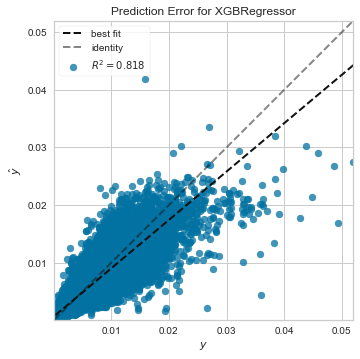

In [24] used 7.8086 MiB RAM in 2.01s, peaked 126.94 MiB above current, total RAM usage 1464.05 MiB


In [24]:
try:
    #if X_test.shape[0] > 0:
    if TRAIN_TEST:
        from yellowbrick.regressor import PredictionError
        visualizer = PredictionError(est)
        visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
        visualizer.score(X_test, y_test)  # Evaluate the model on the test data
        ax_subplot = visualizer.show()        
except ModuleNotFoundError:
    print('no yellowbrick')

In [33]:
if ENV_HOME:
    import eli5
    display(eli5.show_weights(est, feature_names=feature_cols, top=30))

Weight,Feature
0.4758,realized_vol_log_return_wap_linear
0.1730,realized_vol_log_return_wap_linear2
0.1556,realized_vol_log_return_wap2_linear
0.0280,realized_vol_log_return_wap_uniform
0.0139,realized_vol_log_return_wap2_linear2
0.0112,realized_vol_log_return_wap_half0half1
0.0073,realized_vol_log_return_price_uniform
0.0070,realized_vol_log_return_wap_uniform_gt400secs
0.0037,ask_size1_nunique
0.0037,realized_vol_log_return_wap2_half0half1


In [33] used 0.0000 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 1578.60 MiB


In [26]:
if 'feature_importances_' in dir(est):
    feature_col = 'feature_importances_'
elif 'coef_' in dir(est):
    feature_col = 'coef_'
df_features = pd.DataFrame(zip(getattr(est, feature_col), feature_cols), columns=['importance', 'feature']).set_index('importance')
df_features.sort_index(ascending=False)

,feature
importance,
0.319635,realized_vol_log_return_wap_linear
0.289244,realized_vol_log_return_wap_linear2
0.141973,realized_vol_log_return_wap2_linear
0.089793,realized_vol_log_return_wap_uniform
0.021855,realized_vol_log_return_wap2_linear2
...,...
0.001387,realized_vol_log_return_wap_half0half1
0.001382,ask_price1_min
0.001285,bid_price2_max


In [26] used 0.0000 MiB RAM in 0.17s, peaked 0.00 MiB above current, total RAM usage 1463.09 MiB


# Make predictions

In [27]:
len(stock_ids) # expecting 112

112

In [27] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1463.09 MiB


In [28]:
if USE_TEST_LOCAL_6_ITEMS: # True if debugging
    # book train as a substitute
    df_test_all = pd.read_csv(os.path.join(ROOT, 'test_local.csv'))
    df_test_all = df_test_all.rename(columns={'target': 'train_target'})
    TEST_FOLDER = 'book_test_local.parquet'
    assert ENV_HOME == True
else:
    df_test_all = pd.read_csv(TEST_CSV)
    if df_test_all.shape[0] == 3: # kaggle test data
        df_test_all = df_test_all[:1] # cut out 2 rows so predictions work    
    TEST_FOLDER = 'book_test.parquet'
print(ROOT, TEST_FOLDER)
df_test_all = df_test_all.set_index(['stock_id', 'time_id'])

show_details(df_test_all)

/home/ian/data/kaggle/optiver_volatility/ book_test.parquet
[2c] 1x1, 0 nulls, is_view True, is_single_block True, is_consolidated True
In [28] used 0.0000 MiB RAM in 0.11s, peaked 0.00 MiB above current, total RAM usage 1463.09 MiB


In [29]:
test_set_predictions = []
stock_ids_test = get_training_stock_ids(TEST_FOLDER) # all stocks by default

df_test_predictions = pd.DataFrame() # prediction set to build up
for stock_id in tqdm(stock_ids_test):
    df_test_all_X = df_test_all.query('stock_id==@stock_id').copy()
    test_merged = load_data_build_features(stock_id, ROOT, TEST_FOLDER, 'trade_test.parquet', cols, df_test_all)
    test_set_predictions_X = est.predict(test_merged.reset_index()[list(features) + ['stock_id']])
    df_test_all_X['target'] = test_set_predictions_X
    df_test_predictions = pd.concat((df_test_predictions, df_test_all_X))
    
assert df_test_all.shape[0] == df_test_predictions.shape[0], "Expecting all rows to be predicted"

  0%|                                                                                                                                                                                                                   | 0/1 [00:00<?, ?it/s]


AssertionError: row_lengths are different for stock 0: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]

In [29] used 0.8711 MiB RAM in 0.44s, peaked 0.00 MiB above current, total RAM usage 1463.96 MiB


In [ ]:
print(f"Writing {df_test_predictions.shape[0]} rows to submission.csv on {datetime.datetime.utcnow()}")
df_test_predictions.reset_index()[['row_id', 'target']].to_csv('submission.csv', index=False)
show_details(df_test_predictions)
print(f'Notebook took {datetime.datetime.utcnow()-t1_notebook_start} to run')

In [ ]:
if not ENV_HOME:
    assert USE_ALL_STOCK_IDS, "If we're on Kaggle but not using all stock_ids, we're not ready to submit, so fail here to remind me to change USSE_ALL_STOCK_IDS!"

Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/
